<a href="https://colab.research.google.com/github/Miller76lite/GEOL558/blob/main/Final_Supervised_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Supervised First Pass
###Context
#####Knowing the type of rock, knowing the properties and characteristics is very important in the mining and energy industry, so this Dataset details the geochemical variations and compositions (SiO2, TiO2, Al2O3, Fe2O3, …..)of different types of rock.
#####The objective of this data set is focused on finding interesting characteristics and being able to find the type of rock given a series of properties.

### Goal:
####Create a supervised model that uses common rock-forming compounds to identify rock types.

## Install and import required libraries for EDA

In [ ]:
!pip install seaborn==0.13.2

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

###Bring Data from github to colab

In [ ]:
Data = pd.read_csv('https://raw.githubusercontent.com/Miller76lite/GEOL558/main/Data1.csv')

###Start of EDA
##### This EDA shows shape of the data set, includes brief cleaning of the data and shows pair plots, correlation heat map and CDF plots.

In [ ]:
Data.shape

(4162, 13)

In [ ]:
Data.describe()

,long,lat,SiO2n,TiO2n,Al2O3n,FeO*n,MnOn,MgOn,CaOn,Na2On,K2On,P2O5n
count,4118.000000,4118.000000,4135.000000,4135.000000,4135.000000,4135.000000,3980.000000,4135.000000,4135.000000,4134.000000,4135.000000,3920.000000
mean,-122.193137,45.541801,58.595127,1.164000,16.801287,7.430377,0.141910,3.679231,7.099359,3.556638,1.296281,0.253989
std,0.432682,1.270632,6.917297,0.487531,1.588845,2.580065,0.142415,2.112921,2.741486,0.752476,0.953438,0.138934
min,-123.249000,41.656000,45.420000,0.000000,3.230000,0.110000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000
25%,-122.533075,44.652000,53.375000,0.850000,15.870000,5.810000,0.100000,2.340000,5.380000,3.110000,0.640000,0.170000
50%,-122.254250,46.099000,56.990000,1.150000,16.830000,7.870000,0.140000,3.570000,7.460000,3.560000,1.030000,0.230000
75%,-121.881000,46.375800,62.580000,1.440000,17.760000,9.150000,0.170000,4.725000,9.040000,4.030000,1.650000,0.310000
max,-120.531700,48.358300,83.730000,3.640000,25.040000,16.380000,6.150000,16.680000,18.130000,7.000000,9.580000,1.650000


In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4162 entries, 0 to 4161
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rock_name  4122 non-null   object 
 1   long       4118 non-null   float64
 2   lat        4118 non-null   float64
 3   SiO2n      4135 non-null   float64
 4   TiO2n      4135 non-null   float64
 5   Al2O3n     4135 non-null   float64
 6   FeO*n      4135 non-null   float64
 7   MnOn       3980 non-null   float64
 8   MgOn       4135 non-null   float64
 9   CaOn       4135 non-null   float64
 10  Na2On      4134 non-null   float64
 11  K2On       4135 non-null   float64
 12  P2O5n      3920 non-null   float64
dtypes: float64(12), object(1)
memory usage: 422.8+ KB


As we can see from the data information, we have 4162 entries, and each column is missing some amount of data. This will be cleaned below by removing any rows with blank cells from the dataset. This will help the model later achieve the goal by only including data with rock names. we will also remove the Longitude and latitude from this data set. It will not provide useful data for this study.

In [ ]:
data_cleaned = Data.copy()  # Create a copy to avoid modifying the original DataFrame

# Drop rows with blank cells in the 'rock_name' column
data_cleaned = data_cleaned.dropna(subset=['rock_name'])

# Reset the index after dropping rows
data_cleaned = data_cleaned.reset_index(drop=True)

# Drop Lat and long colums as they may cause issues with the ML process and are not needed
data_cleaned = data_cleaned.drop(['long', 'lat'], axis=1)

In [ ]:
rock_names = data_cleaned['rock_name'].unique()
rock_names.sort()  # Sort the rock names alphabetically
print(rock_names)

['Altered andesite' 'Andesite' 'Andesite ' 'Andesite  sill'
 'Andesite and microdiorite sill' 'Andesite breccia' 'Andesite dike'
 'Andesite dike?' 'Andesite intrusion' 'Andesite intrusion '
 'Andesite intrusion?' 'Andesite plug' 'Andesite sill' 'Andesite sill?'
 'Andesite tuff' 'Andesite tuff breccia' 'Andesite/microdiorite sill'
 'Aplite' 'Basalt' 'Basalt dike' 'Basalt intrusion' 'Basalt intrusion?'
 'Basalt plug' 'Basalt scoria' 'Basalt sill' 'Basalt tuff'
 'Basalt/microdiorite sill' 'Basaltic andesite' 'Basaltic andesite  sill'
 'Basaltic andesite aphanite' 'Basaltic andesite breccia'
 'Basaltic andesite dike' 'Basaltic andesite intrusion'
 'Basaltic andesite intrusion ' 'Basaltic andesite sill'
 'Basaltic andesite tuff' 'Basaltic andesite tuff and lava'
 'Basaltic andesite/microdiorite sill' 'Basaltic plug' 'Breccia' 'Dacite'
 'Dacite ' 'Dacite  ' 'Dacite  tuff' 'Dacite aphanite' 'Dacite breccia'
 'Dacite dike' 'Dacite intrusion' 'Dacite plug' 'Dacite sill'
 'Dacite sill?' 'Dacite 

In [ ]:
data_cleaned['rock_name'] = data_cleaned['rock_name'].str.replace(r'(^Andesite.*$)', 'Andesite', regex=True)
data_cleaned['rock_name'] = data_cleaned['rock_name'].str.replace(r'(^Basalt.*$)', 'Basalt', regex=True)
data_cleaned['rock_name'] = data_cleaned['rock_name'].str.replace(r'(^Dacite.*$)', 'Dacite', regex=True)
data_cleaned['rock_name'] = data_cleaned['rock_name'].str.replace(r'(^Diorite.*$)', 'Diorite', regex=True)
data_cleaned['rock_name'] = data_cleaned['rock_name'].str.replace(r'(^Gabbro.*$)', 'Gabbro', regex=True)
data_cleaned['rock_name'] = data_cleaned['rock_name'].str.replace(r'(^Granite.*$)', 'Granite', regex=True)
data_cleaned['rock_name'] = data_cleaned['rock_name'].str.replace(r'(^Granodiorite.*$)', 'Granodiorite', regex=True)
data_cleaned['rock_name'] = data_cleaned['rock_name'].str.replace(r'(^Rhyolite.*$)', 'Rhyolite', regex=True)
data_cleaned['rock_name'] = data_cleaned['rock_name'].str.replace(r'(.*quartz.*)', 'Quartz diorite', regex=True, case=False)
data_cleaned['rock_name'] = data_cleaned['rock_name'].str.replace(r'(^Monzogranite.*$)', 'Monzogranite', regex=True)
data_cleaned['rock_name'] = data_cleaned['rock_name'].str.replace(r'(^Microdiorite.*$)', 'Microdiorite', regex=True)
# Print the new unique rock names
new_unique_rocks = data_cleaned['rock_name'].unique()
new_unique_rocks.sort()
print(new_unique_rocks)

['Altered andesite' 'Andesite' 'Aplite' 'Basalt' 'Breccia' 'Dacite'
 'Diorite' 'Gabbro' 'Granite' 'Granodiorite' 'Granophyre'
 'Hydroclastic breccia' 'Intrusion' 'Microdiorite' 'Microgabbro'
 'Monzogranite' 'Quartz diorite' 'Rhyolite' 'Silicic dike' 'Tonalite'
 'Volcanic breccia']


In [ ]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4122 entries, 0 to 4121
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rock_name  4122 non-null   object 
 1   SiO2n      4122 non-null   float64
 2   TiO2n      4122 non-null   float64
 3   Al2O3n     4122 non-null   float64
 4   FeO*n      4122 non-null   float64
 5   MnOn       3967 non-null   float64
 6   MgOn       4122 non-null   float64
 7   CaOn       4122 non-null   float64
 8   Na2On      4121 non-null   float64
 9   K2On       4122 non-null   float64
 10  P2O5n      3907 non-null   float64
dtypes: float64(10), object(1)
memory usage: 354.4+ KB


In [ ]:
# Calculate the number of columns in the original DataFrame
original_rows = Data.shape[0]

# Calculate the number of columns in the cleaned DataFrame
cleaned_rows = data_cleaned.shape[0]

# Calculate the number of columns dropped
dropped_rows = original_rows - cleaned_rows

# Print the result
print(f"Number of rows dropped due to empty cells/missing data: {dropped_rows}")

Number of rows dropped due to empty cells/missing data: 40


As we can see, there were 40 empty cells in the data. Below are the remaining missing values. I will keep this data as is because I would like to see if the supervised model can still predict the rock type with some missing data.

In [ ]:
# Check for missing values after cleaning
print("Missing values after cleaning:\n", data_cleaned.isnull().sum())
# Select numerical features
numerical_features = data_cleaned.select_dtypes(include=np.number).columns
data_cleaned_numerical = data_cleaned[numerical_features]

Missing values after cleaning:
 rock_name      0
SiO2n          0
TiO2n          0
Al2O3n         0
FeO*n          0
MnOn         155
MgOn           0
CaOn           0
Na2On          1
K2On           0
P2O5n        215
dtype: int64


###Pair plots of each Compound

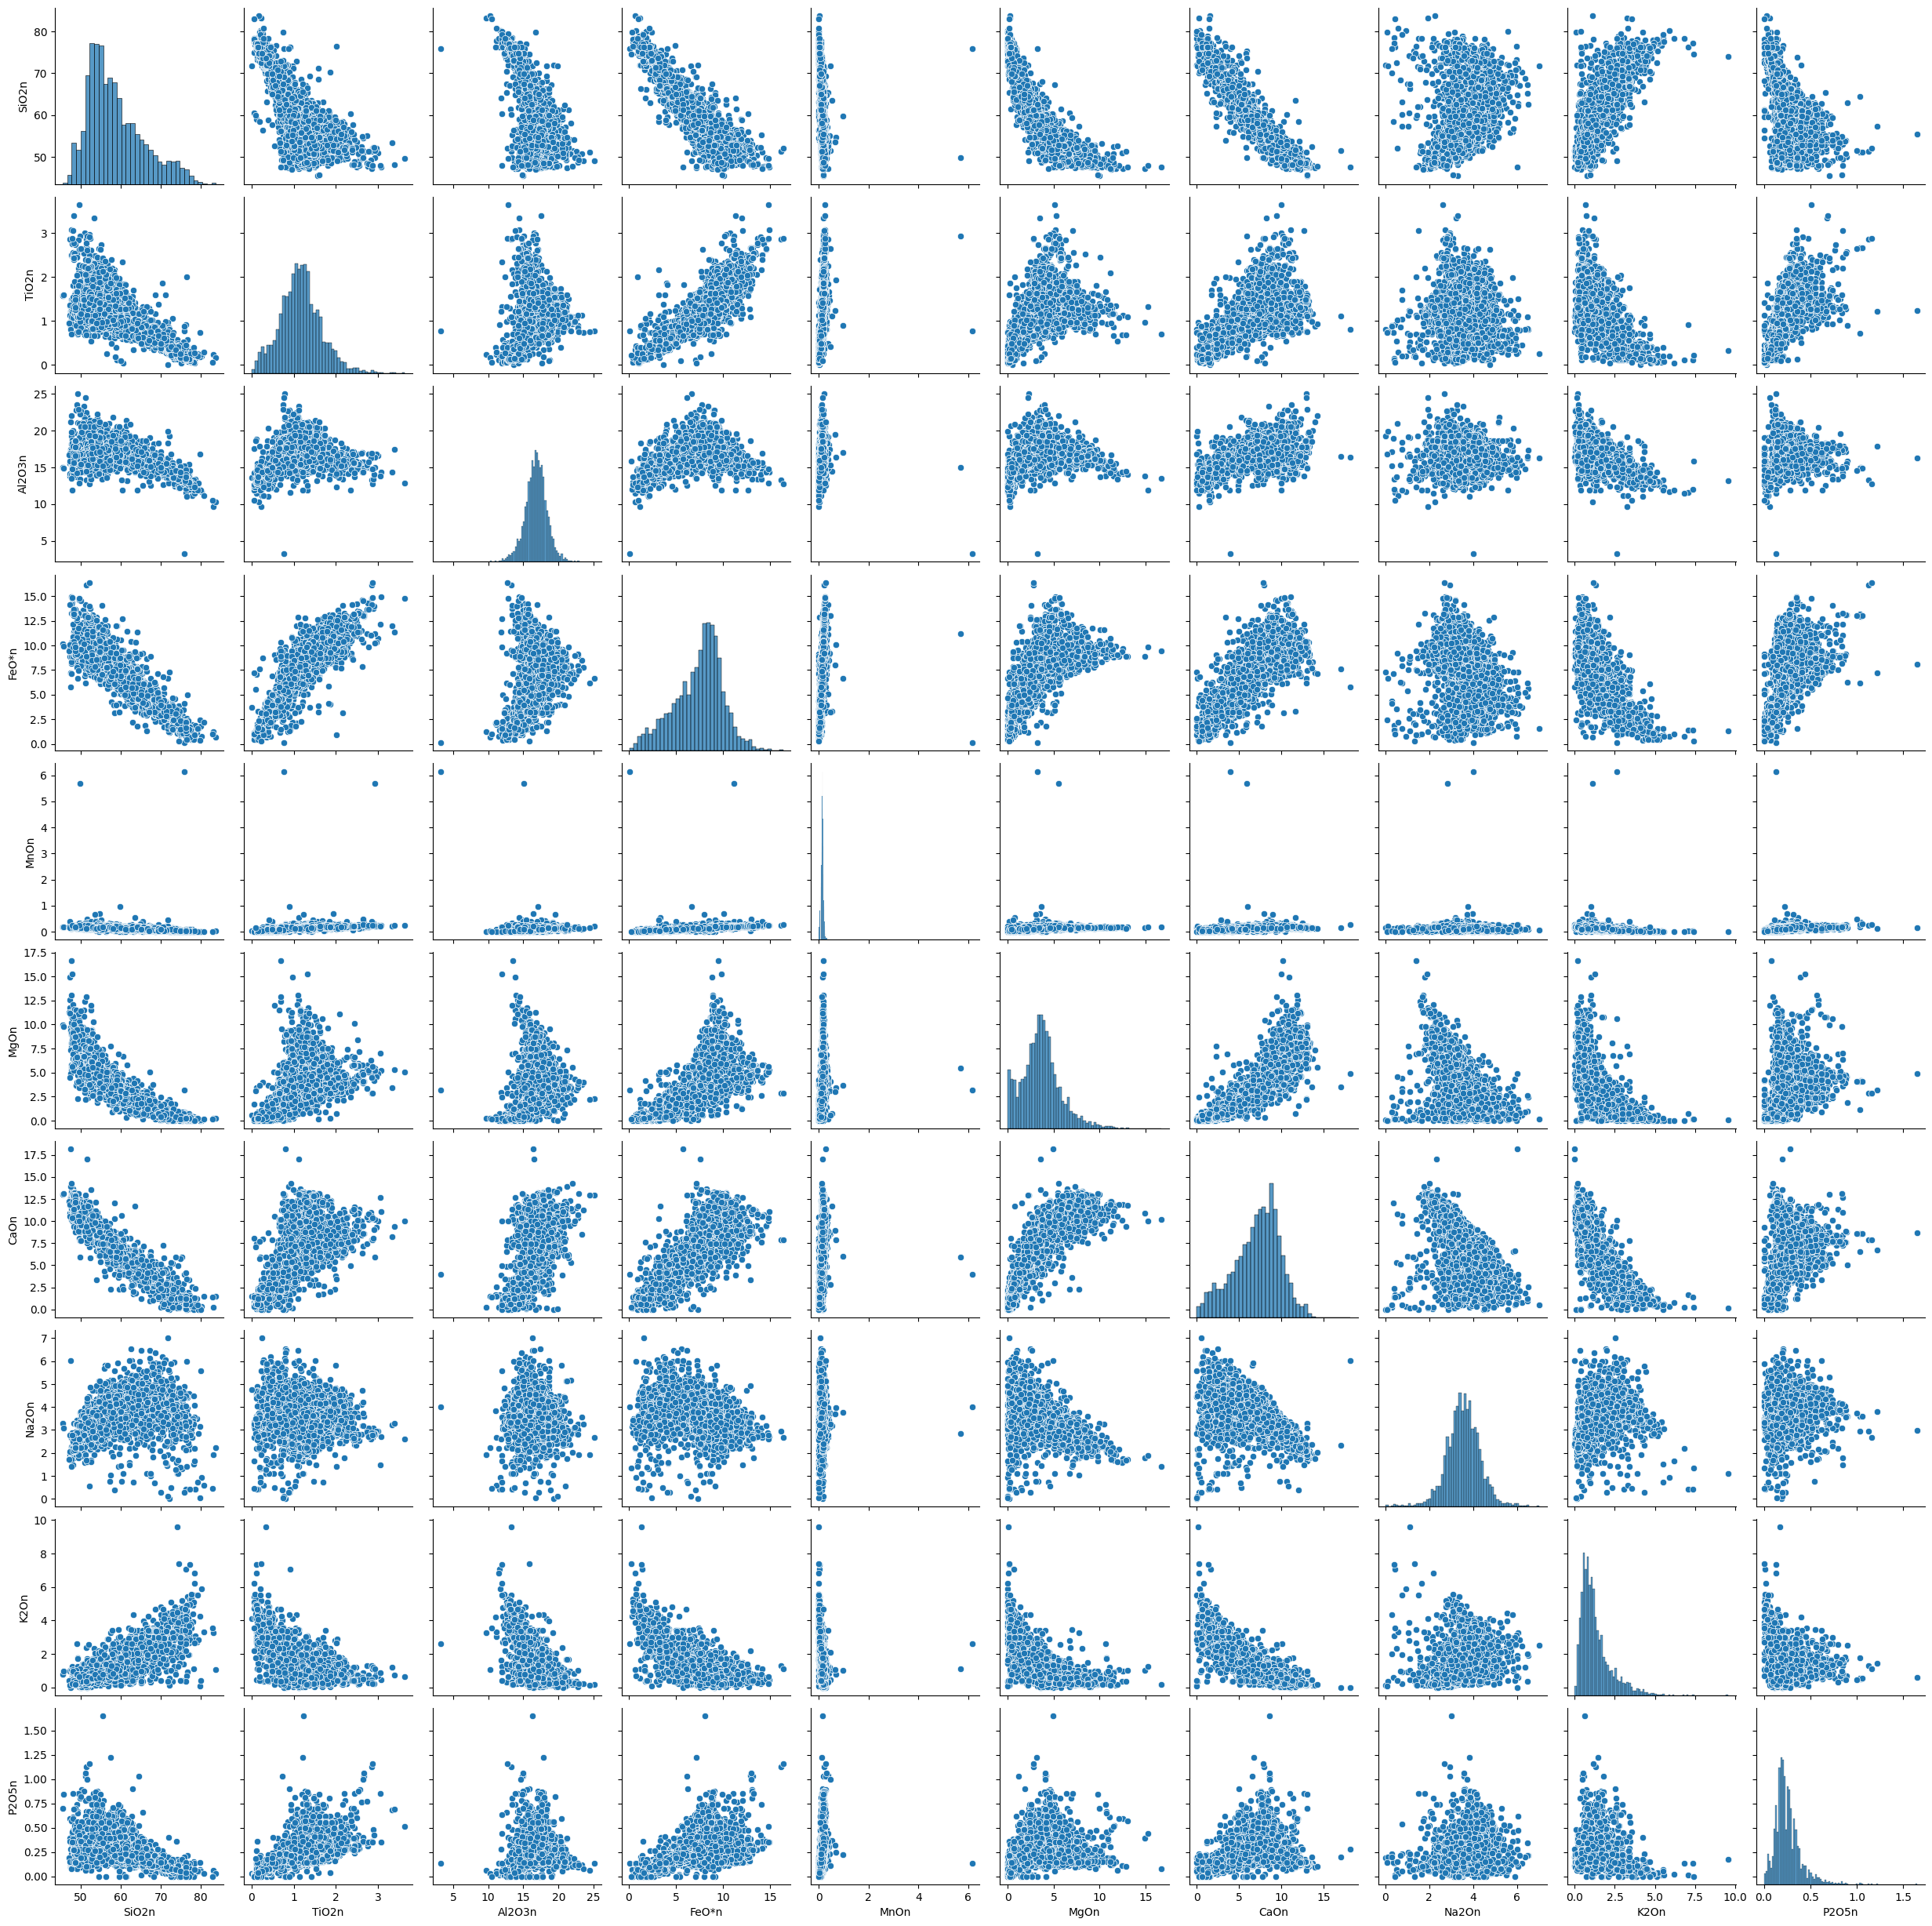

In [ ]:
numeric_columns = data_cleaned.select_dtypes(include='number').columns
sns.pairplot(data_cleaned[numeric_columns])
plt.show()

In [ ]:
correlation_matrix = data_cleaned.corr(numeric_only=True)

###Correlation Heat Map

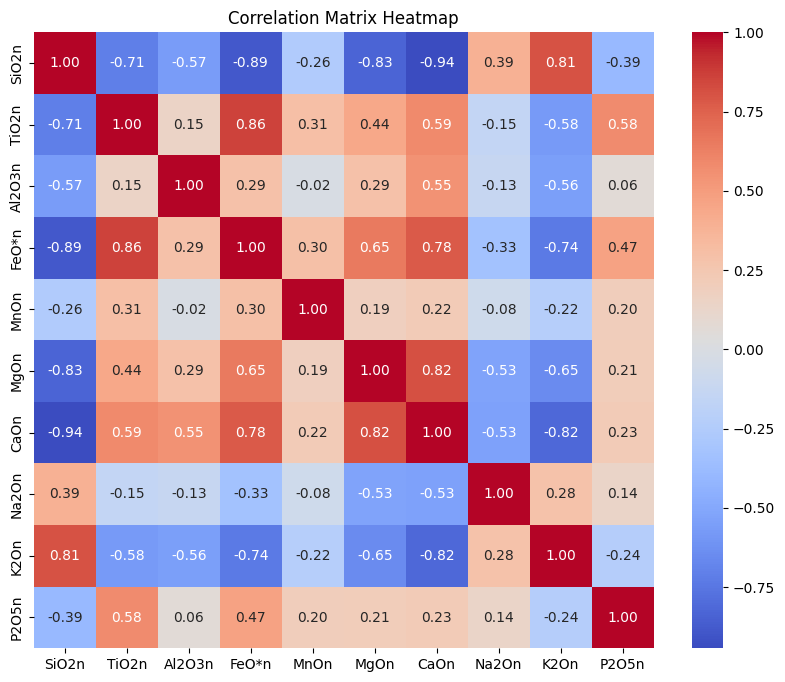

In [ ]:
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

### ECDF Plots

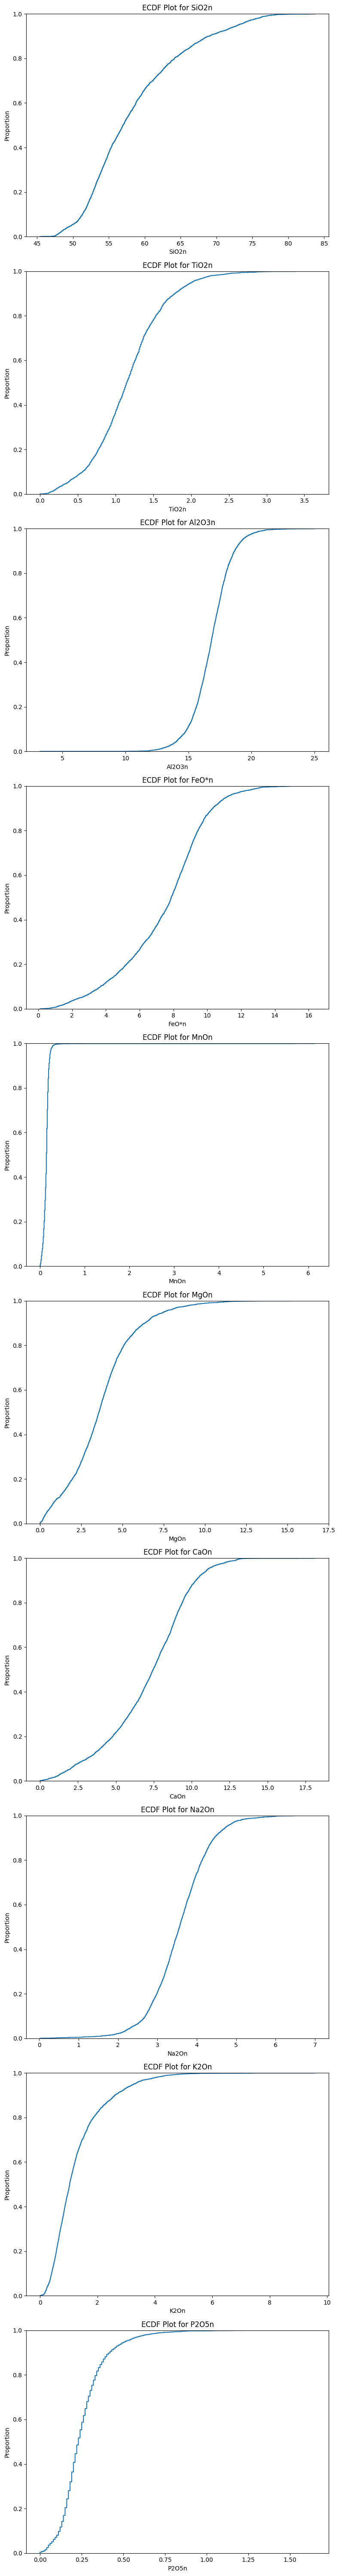

In [ ]:
numeric_columns = data_cleaned.select_dtypes(include='number').columns
# Create ECDF plots for all numerical variables
fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(8, 6 * len(numeric_columns))) # Create subplots

for i, column in enumerate(numeric_columns):
    sns.ecdfplot(data=data_cleaned, x=column, ax=axes[i])  # Plot ECDF on the subplot
    axes[i].set_title(f"ECDF Plot for {column}")  # Set title for each subplot

plt.tight_layout()  # Adjust subplot spacing to prevent overlap
plt.show()

As we can see from the EDA, there are visible correlations in the pair plots that are confirmed by the correlation heat map. The CDF plots show that some of the variables are normally distributed, while others are concentrated.

## Define features for Supervised models

This code prepares the data for machine learning. It first separates the data into two parts: the features we'll use to make predictions (X), and the target we want to predict (y), which is the rock type. Then, it splits the data into a training set (used to teach the model) and a testing set (used to evaluate how well the model learned). Finally, it cleans up the data by filling in any missing values and scaling the features so they have a similar range. These steps are crucial because they help the machine learning model learn effectively from the data and make accurate predictions on new, unseen data.

In [ ]:
# Define features (X) and target (y)
X = data_cleaned.drop('rock_name', axis=1)
y = data_cleaned['rock_name']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Imputation and scaling
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train = scaler.fit_transform(imputer.fit_transform(X_train))
X_test = scaler.transform(imputer.transform(X_test))

## Logistic Regression Model

This logistic regression model is like a rock identifier that learns from examples. It's trained on data containing the chemical composition of various rocks and their corresponding types. By studying this data, the model learns to associate specific chemical patterns with each rock type. Once trained, it can predict the type of an unknown rock based solely on its chemical makeup. This is useful in geology and mining, allowing quick identification without complex laboratory tests. It's also valuable for understanding which chemical components are most indicative of each rock type, giving scientists further insights into rock formation. Ultimately, this model acts as a powerful tool for simplifying and automating rock classification, saving time and resources.
The example below will explain how we are getting our variables below. Imagine the model as a rock-sorting machine. Precision is like its accuracy in picking out one specific type of rock – say, granite. If the machine labels 10 rocks as granite, and 9 are actually granite, its precision for granite is 90%. Recall, on the other hand, measures how well the machine finds all the granite in a pile. If there are 15 granite rocks, and the machine correctly identifies 12, its recall for granite is 80%. The F1-score combines precision and recall to give an overall performance rating for identifying granite. Finally, support simply tells us how many granite rocks were in the pile, in this case, 15. These metrics together paint a detailed picture of how well the model performs in identifying each specific rock type, not just its overall accuracy.

In [ ]:
lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr}")
print(f"Logistic Regression Classification Report:\n{report_lr}\n")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.8048484848484848
Logistic Regression Classification Report:
                      precision    recall  f1-score   support

            Andesite       0.70      0.90      0.79       207
              Aplite       0.00      0.00      0.00         2
              Basalt       0.92      0.95      0.93       389
             Breccia       0.00      0.00      0.00         1
              Dacite       0.67      0.75      0.71        71
             Diorite       1.00      0.04      0.07        28
              Gabbro       0.00      0.00      0.00         2
             Granite       0.64      0.78      0.70        32
        Granodiorite       0.62      0.35      0.44        23
          Granophyre       0.00      0.00      0.00         1
Hydroclastic breccia       0.00      0.00      0.00         1
           Intrusion       0.00      0.00      0.00         2
        Microdiorite       0.00      0.00      0.00         2
      Quartz diorite       0.00      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


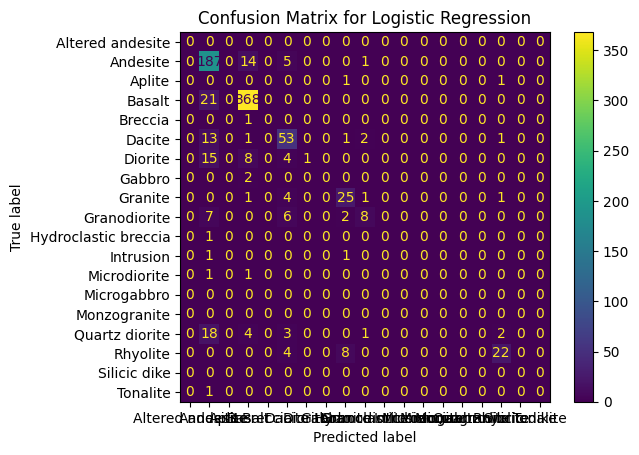

In [ ]:
cm = confusion_matrix(y_test, y_pred_lr, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot()
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

## K-Nearest Neighbors (KNN)

The KNN model is like a rock identifier that relies on comparing unknown rocks to its collection of known examples. Imagine it has a library of rocks with their chemical compositions and types. When presented with a new rock, it finds the 'k' rocks in its library that are most similar in composition. It then predicts the new rock's type based on the most common type among those 'k' nearest neighbors. It's essentially a "majority vote" among the most similar examples. Similar to the logistic regression model, the primary output of the KNN model is a prediction of the rock type. When given the chemical makeup of a new rock, it will output the type it believes is most likely, based on the types of its nearest neighbors. To get this prediction, you'd use:

The interpretation of these metrics for the KNN model is the same as for the logistic regression model.

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn}")
print(f"KNN Classification Report:\n{report_knn}\n")

KNN Accuracy: 0.8048484848484848
KNN Classification Report:
                      precision    recall  f1-score   support

            Andesite       0.73      0.84      0.78       207
              Aplite       0.00      0.00      0.00         2
              Basalt       0.90      0.93      0.92       389
             Breccia       0.00      0.00      0.00         1
              Dacite       0.76      0.73      0.75        71
             Diorite       0.55      0.39      0.46        28
              Gabbro       0.00      0.00      0.00         2
             Granite       0.58      0.91      0.71        32
        Granodiorite       0.56      0.39      0.46        23
          Granophyre       0.00      0.00      0.00         1
Hydroclastic breccia       0.00      0.00      0.00         1
           Intrusion       0.00      0.00      0.00         2
        Microdiorite       0.00      0.00      0.00         2
      Quartz diorite       0.67      0.21      0.32        28
         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


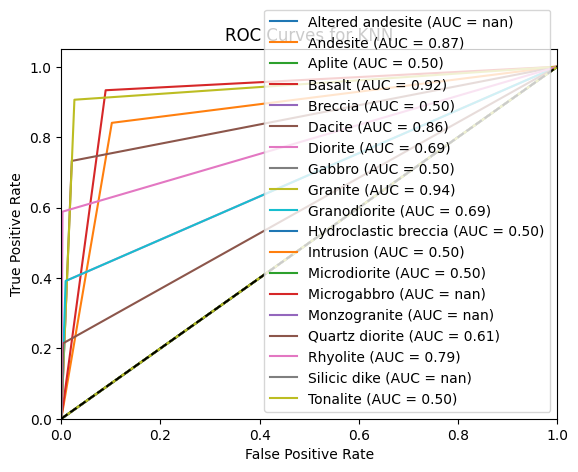

In [ ]:
# Binarize the target labels
y_test_bin = label_binarize(y_test, classes=knn_model.classes_)
y_pred_bin = label_binarize(y_pred_knn, classes=knn_model.classes_)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(knn_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
for i in range(len(knn_model.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'{knn_model.classes_[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for KNN')
plt.legend(loc='lower right')
plt.show()

## GradientBoostingClassifier

The GBC model is like a team of rock identifiers working together to improve prediction accuracy. It starts with a simple model and gradually adds more complex models, each focusing on correcting the mistakes of the previous ones. This process of combining "weak learners" into a stronger ensemble makes the GBC model very powerful for classification tasks. It essentially learns from its errors to make increasingly accurate predictions. Just like the logistic regression and KNN models, the primary output of the GBC model is a prediction of the rock type. When you give it the chemical composition of an unknown rock, it will output the rock type it believes is most likely, based on the collective knowledge of its ensemble of models. You get the prediction using

The interpretation of these metrics for the GBC model remains the same.

In [ ]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
report_gb = classification_report(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {accuracy_gb}")
print(f"Gradient Boosting Classification Report:\n{report_gb}\n")

Gradient Boosting Accuracy: 0.8254545454545454
Gradient Boosting Classification Report:
                      precision    recall  f1-score   support

    Altered andesite       0.00      0.00      0.00         0
            Andesite       0.83      0.86      0.84       207
              Aplite       0.00      0.00      0.00         2
              Basalt       0.92      0.96      0.94       389
             Breccia       0.00      0.00      0.00         1
              Dacite       0.74      0.87      0.80        71
             Diorite       0.47      0.29      0.36        28
              Gabbro       0.00      0.00      0.00         2
             Granite       0.67      0.69      0.68        32
        Granodiorite       0.37      0.30      0.33        23
          Granophyre       0.00      0.00      0.00         1
Hydroclastic breccia       0.00      0.00      0.00         1
           Intrusion       0.00      0.00      0.00         2
        Microdiorite       0.00      0.00  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

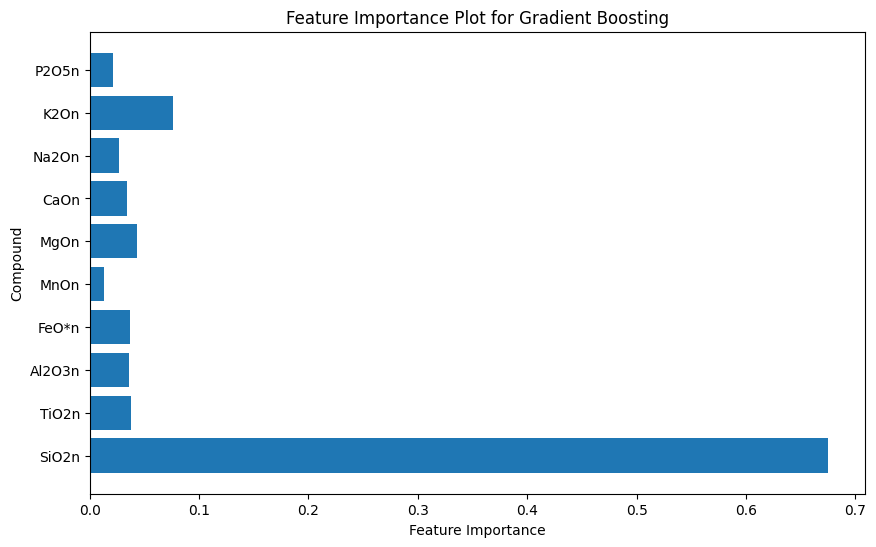

In [ ]:
feature_importances = gb_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Compound')
plt.title('Feature Importance Plot for Gradient Boosting')
plt.show()

Scoring and finding out which supervised model is the most accurate.

In [ ]:
# Create a dictionary to store the accuracy scores
model_accuracies = {
    "Logistic Regression": accuracy_lr,
    "KNN": accuracy_knn,
    "Gradient Boosting": accuracy_gb
}

# Find the model with the highest accuracy
best_model = max(model_accuracies, key=model_accuracies.get)

# Print the results
print("Model Accuracies:")
for model, accuracy in model_accuracies.items():
    print(f"{model}: {accuracy:.4f}")

print(f"\nThe best-performing model is: {best_model} with an accuracy of {model_accuracies[best_model]*100:.4f}")

Model Accuracies:
Logistic Regression: 0.8048
KNN: 0.8048
Gradient Boosting: 0.8255

The best-performing model is: Gradient Boosting with an accuracy of 82.5455


##Which method did you like the most?
#### The method I like the most is the Gradient Boosting Classifier. This is simply because it had the highest score amongst the three which is the ideal outcome, especially since this is supposed to help reduce the time it takes to ID rocks.

##Which method did you like the least?
#### The method i liked the least is the KNN model. This is because it had the smallest score amongst the three and could cause significantly more incorrect ID's when used.

##How did you score these supervised models?
#### The models were evaluated based on their accuracy in predicting rock types. Each model was trained using a portion of the data and then tested on a separate, unseen portion. By comparing the model's predictions to the actual rock types in the test data, an accuracy score was calculated, representing the percentage of correct classifications. This process allowed us to see how well each model learned from the data and could generalize to new, unknown rocks. The model with the highest accuracy was deemed the best performer, indicating its ability to make more reliable predictions about rock types based on their chemical compositions.

##Did the output align with your geologic understanding?
#### While the models' predictions generally aligned with my geological understanding, my expertise in igneous petrology and the level of detail in the rock type classifications are somewhat limited. I recognize potential sources of error, particularly when data points fall near the boundaries between igneous rock types. Simplifying the rock type categories could potentially improve the models' accuracy and further align with my geological interpretations.

##Did you hyperparameter tune? Why or why not?
#### No, I did not perform hyperparameter tuning for the models in this initial exploration. Establishing a baseline performance with default settings is a valuable first step, providing a foundation for future refinements. This approach ensures a more systematic and efficient process towards achieving the best possible performance.

##How did you split your data? and why does that make sense for this dataset?
#### The data was split into 80% for training and 20% for testing using the train_test_split function. This is crucial to evaluate how well the models generalize to unseen data and prevents overfitting where models perform well on training data but poorly on new data. It provides an unbiased estimate of model performance, allowing comparison and selection of the best model for classifying unknown rocks based on chemical composition—essential for real-world applications in geology and mining.

##What did you want to learn more about?
#### I'm interested in gaining a deeper understanding of the model's misclassifications. Visualizing these errors on an igneous petrology compound ternary diagram could provide insights into specific areas where the model struggles. This information could guide further fine-tuning and adjustments to enhance its performance

##Did you pre-process your data?
### Do all models require pre-processing?
####The data was pre-processed by handling missing values using a SimpleImputer and scaling numerical features using a StandardScaler. Pre-processing is crucial for many machine learning algorithms to improve performance, handle missing values, and ensure consistent data representation. However, some models, like tree-based models, might not require extensive pre-processing.